In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, explode, split, lower, month, sum, year, concat, avg, min, max
import pyspark.sql.functions as f


In [2]:
spark = SparkSession.builder.appName("Project").getOrCreate()

data = spark.read.csv(path='charts.csv',
                         sep=',',
                         encoding='UTF-8',
                         comment=None,
                         header=True,
                         inferSchema=True)

In [3]:
data.show(n=5, truncate=False)


+---------------------------+----+----------+-------------------------------------+-----------------------------------------------------+---------+------+-------------+-------+
|title                      |rank|date      |artist                               |url                                                  |region   |chart |trend        |streams|
+---------------------------+----+----------+-------------------------------------+-----------------------------------------------------+---------+------+-------------+-------+
|Chantaje (feat. Maluma)    |1   |2017-01-01|Shakira                              |https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg|Argentina|top200|SAME_POSITION|253019 |
|Vente Pa' Ca (feat. Maluma)|2   |2017-01-01|Ricky Martin                         |https://open.spotify.com/track/7DM4BPaS7uofFul3ywMe46|Argentina|top200|MOVE_UP      |223988 |
|Reggaetón Lento (Bailemos) |3   |2017-01-01|CNCO                                 |https://open.spotify.com/track/3

In [4]:
print( data.count())


26173514


In [5]:
data.printSchema()


root
 |-- title: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: string (nullable = true)



In [6]:
#data.select("region").distinct().collect()
#data.select("date").distinct().collect()
#data.select("chart").distinct().collect()

data = data.filter(~col("region").startswith("https"))
data = data.filter(~col("chart").startswith("https"))
data = data.filter(col("date").startswith("20"))

In [7]:
data = data.withColumn('date', data['date'].cast('date'))
data = data.withColumn('month', month('date'))
data = data.withColumn('year', year('date'))

min_value = data.select(min('date')).first()[0]
max_value = data.select(max('date')).first()[0]
print(min_value, max_value)

2017-01-01 2021-12-31


In [11]:
def find_missing_values_columns(df):
    nrow = df.count()
    for v in df.columns:
        summary_df = df.select(v).describe()
        v_count = int(summary_df.collect()[0][v])
        if v_count < nrow:
            missing_percentage = (1 - v_count/nrow) * 100
            print( #"Total observations: " + str(nrow) + "\n"
                 #"Total observations of " + v + ": " + str(v_count) + "\n"
                 "Percentage of missing values: " + str(missing_percentage) + "%" + "\n")


In [10]:
data_agg = data.agg(*[f.count(f.when(f.isnull(col), col)).alias(col) for col in data.columns])
data_agg.show()

+-----+----+----+------+---+------+-----+-----+-------+-----+----+
|title|rank|date|artist|url|region|chart|trend|streams|month|year|
+-----+----+----+------+---+------+-----+-----+-------+-----+----+
|    0|   0|   0|     0|  0|     0|    0|    0|5848001|    0|   0|
+-----+----+----+------+---+------+-----+-----+-------+-----+----+



In [8]:
data.groupBy("artist", "title") \
                        .agg(count("*").alias("count")) \
                        .select("artist", "count", "title").orderBy('count', ascending=False).show(20)

+--------------------+-----+--------------------+
|              artist|count|               title|
+--------------------+-----+--------------------+
|          Ed Sheeran|68860|        Shape of You|
|     Imagine Dragons|60022|            Believer|
|       Lewis Capaldi|57509|   Someone You Loved|
|         Tones And I|56087|        Dance Monkey|
|          The Weeknd|55770|     Blinding Lights|
|          Ed Sheeran|54301|             Perfect|
|Lady Gaga, Bradle...|47815|             Shallow|
|       Billie Eilish|44821|             bad guy|
|            Dua Lipa|44639|     Don't Start Now|
|Post Malone, Swae...|43508|Sunflower - Spide...|
|Shawn Mendes, Cam...|42493|            Señorita|
|        Harry Styles|41473|    Watermelon Sugar|
|          Juice WRLD|41451|        Lucid Dreams|
|       Billie Eilish|40932|lovely (with Khalid)|
|           SAINt JHN|40090|Roses - Imanbek R...|
|        James Arthur|39132|Say You Won't Let Go|
|     Imagine Dragons|36944|             Thunder|


In [ ]:
print(data.count())


In [ ]:
data.select("chart").distinct().collect()


In [ ]:
data.select("region").distinct().collect()


In [ ]:
data.groupBy("artist").count().show()


In [13]:
top_artist_df = data.groupBy('artist', "title") \
                                 .agg({'streams': 'mean'}) \
                                 .withColumnRenamed("avg(streams)", "Average streams") \
                                 .orderBy('avg(streams)', ascending=False).show(10)

+--------------------+--------------------+------------------+
|              artist|               title|   Average streams|
+--------------------+--------------------+------------------+
|Tyler, The Creato...|           WUSYANAME|         2984550.0|
|Tyler, The Creato...|           LEMONHEAD|2300653.6666666665|
|Tyler, The Creato...|          JUGGERNAUT|2289410.6666666665|
|Nio Garcia, Flow ...|                  Am| 2285392.095238095|
|Tyler, The Creato...|      HOT WIND BLOWS|2039035.3333333333|
|Tyler, The Creato...|      SIR BAUDELAIRE|         1966297.0|
|Tyler, The Creato...|SWEET / I THOUGHT...|1821788.3333333333|
|Tiago PZK, Lit Ki...|      Entre Nosotros|1667961.6666666667|
|Tyler, The Creato...|             RUNITUP|1651658.6666666667|
|Tyler, The Creato...|           MANIFESTO|1488441.6666666667|
+--------------------+--------------------+------------------+
only showing top 10 rows



In [14]:
top_artist_df = data.groupBy('artist', 'title', 'region') \
                                 .agg({'streams': 'mean'}) \
                                 .withColumnRenamed("avg(streams)", "Average streams") \
                                 .orderBy('avg(streams)', ascending=False).show(10)

+--------------------+--------------------+------+------------------+
|              artist|               title|region|   Average streams|
+--------------------+--------------------+------+------------------+
|       The Kid LAROI|STAY (with Justin...|Global| 7064031.842424243|
|               Adele|          Easy On Me|Global| 6648637.852941177|
|DJ Khaled, Justin...|         I'm the One|Global|      5517216.8125|
|           Lil Nas X|INDUSTRY BABY (fe...|Global| 5454019.754966888|
|      Olivia Rodrigo|            good 4 u|Global| 4975875.429864254|
|Drake, Michael Ja...|  Don’t Matter To Me|Global| 4961460.095238095|
|           Lil Nas X|Old Town Road (fe...|Global| 4497122.053571428|
|          Ed Sheeran|          Bad Habits|Global| 4254899.268156424|
|           Lil Nas X|MONTERO (Call Me ...|Global|4182425.2407407407|
|Post Malone, 21 S...|            rockstar|Global|4174250.6383928573|
+--------------------+--------------------+------+------------------+
only showing top 10 

### Popular words in title 

In [15]:
def get_popular_words(df, num_words=10):
    exclude_words = ["(feat.", "(with"]
    words_df = df.select(explode(split(lower(col("title")), " ")).alias("word"))

    words_df = words_df.filter((col("word") != "") & (~col("word").isin(exclude_words)))

    word_counts = words_df.groupBy("word").count()

    sorted_word_counts = word_counts.orderBy(col("count").desc())

    top_words = sorted_word_counts.limit(num_words).collect()

    return [{"word": row["word"], "count": row["count"]} for row in top_words]



In [16]:
popular_words = get_popular_words(data, num_words=30)
a = []
b = []
for word in popular_words:
    print(f"Word: {word['word']}, Count: {word['count']}")
    a.append(word['word'])
    b.append(word['count'])


Word: -, Count: 1975479
Word: the, Count: 1155464
Word: me, Count: 1141120
Word: &, Count: 1129698
Word: you, Count: 1121338
Word: remix, Count: 964527
Word: i, Count: 611034
Word: la, Count: 589045
Word: love, Count: 569453
Word: a, Count: 482683
Word: no, Count: 411290
Word: in, Count: 409978
Word: to, Count: 407252
Word: my, Count: 370680
Word: de, Count: 351393
Word: it, Count: 331806
Word: of, Count: 322763
Word: like, Count: 294245
Word: on, Count: 285163
Word: your, Count: 274591
Word: te, Count: 272743
Word: don't, Count: 253314
Word: el, Count: 250790
Word: for, Count: 220766
Word: let, Count: 209330
Word: be, Count: 205649
Word: que, Count: 203819
Word: go, Count: 203449
Word: mi, Count: 185032
Word: bad, Count: 183696


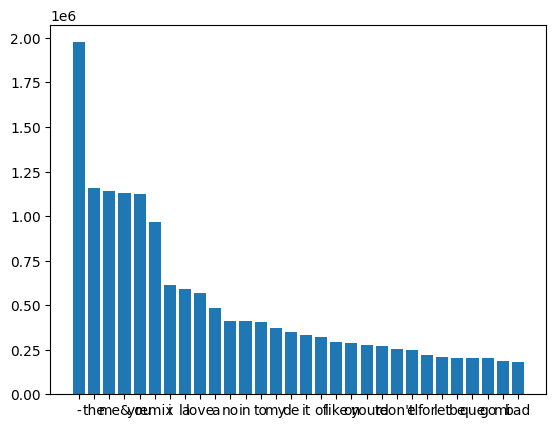

In [17]:
import matplotlib.pyplot as plt
plt.bar(a,b)
plt.show()

## Region 

<BarContainer object of 30 artists>

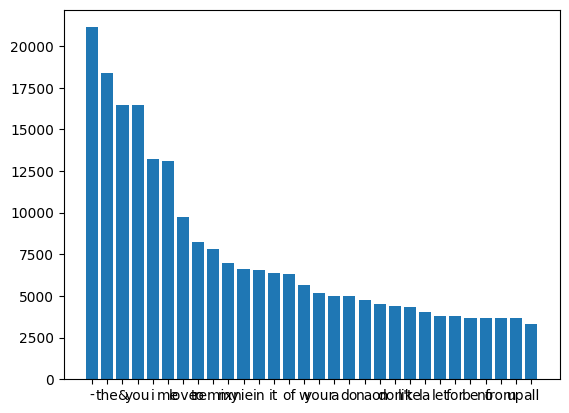

In [18]:
popular_words = get_popular_words(data.filter(data.region == "Poland"), num_words=30)
a = []
b = []
for word in popular_words:
    a.append(word['word'])
    b.append(word['count'])

plt.bar(a,b)


In [19]:
a

['-',
 'the',
 '&',
 'you',
 'i',
 'me',
 'love',
 'to',
 'remix',
 'my',
 'nie',
 'in',
 'it',
 'of',
 'w',
 'your',
 'a',
 'do',
 'na',
 'on',
 "don't",
 'like',
 'la',
 'let',
 'for',
 'be',
 'no',
 'from',
 'up',
 'all']

In [ ]:
popular_words = get_popular_words(data.filter(data.region == "Spain"), num_words=30)
a = []
b = []
for word in popular_words:
    a.append(word['word'])
    b.append(word['count'])

plt.bar(a,b)


In [ ]:
a

<BarContainer object of 30 artists>

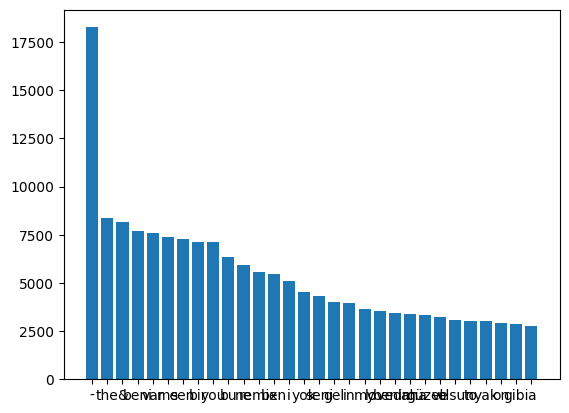

In [113]:
popular_words = get_popular_words(data.filter(data.region == "Turkey"), num_words=30)
a = []
b = []
for word in popular_words:
    a.append(word['word'])
    b.append(word['count'])

plt.bar(a,b)


<BarContainer object of 30 artists>

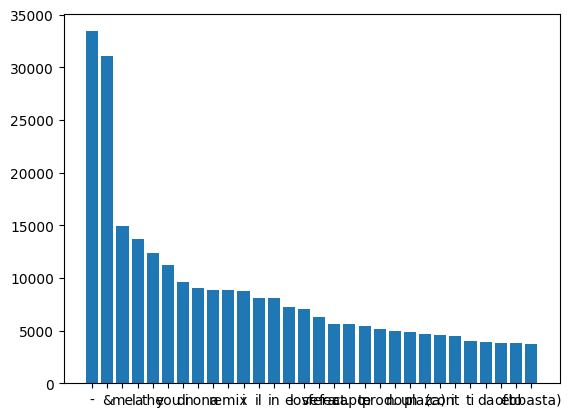

In [115]:
popular_words = get_popular_words(data.filter(data.region == "Italy"), num_words=30)
a = []
b = []
for word in popular_words:
    a.append(word['word'])
    b.append(word['count'])

plt.bar(a,b)


<BarContainer object of 30 artists>

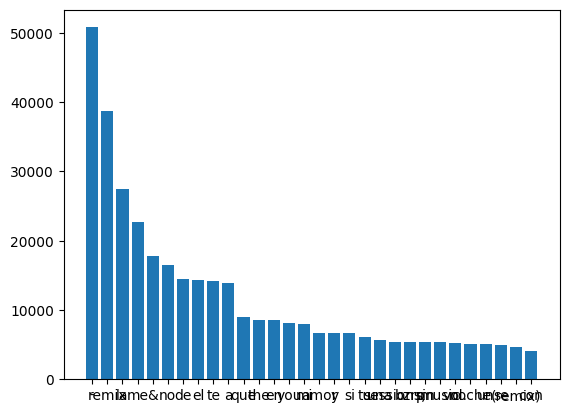

In [114]:
popular_words = get_popular_words(data.filter(data.region == "Argentina"), num_words=30)
a = []
b = []
for word in popular_words:
    a.append(word['word'])
    b.append(word['count'])

plt.bar(a,b)


In [20]:
year_month_data = data.groupBy('year', 'month').agg(avg('streams').alias('avg_streams')).orderBy('year', 'month')


In [21]:
year_month_data.show()


+----+-----+------------------+
|year|month|       avg_streams|
+----+-----+------------------+
|2017|    1| 45672.80626019076|
|2017|    2| 48158.46299433699|
|2017|    3|54839.748438493865|
|2017|    4| 52932.91151331416|
|2017|    5| 53900.16391470911|
|2017|    6|52548.708730231956|
|2017|    7| 50797.59861997136|
|2017|    8| 50369.70107866206|
|2017|    9| 52118.02726822361|
|2017|   10|51161.316962573525|
|2017|   11|51349.900187520114|
|2017|   12| 53969.44279062087|
|2018|    1|52247.701849529054|
|2018|    2|54368.873808568365|
|2018|    3| 54347.01790089554|
|2018|    4|56653.416267703135|
|2018|    5|  54897.4092600806|
|2018|    6| 56088.51702503682|
|2018|    7| 56275.39664786928|
|2018|    8| 53986.27930364628|
+----+-----+------------------+
only showing top 20 rows



In [22]:
year_month_data.collect()


[Row(year=2017, month=1, avg_streams=45672.80626019076),
 Row(year=2017, month=2, avg_streams=48158.46299433699),
 Row(year=2017, month=3, avg_streams=54839.748438493865),
 Row(year=2017, month=4, avg_streams=52932.91151331416),
 Row(year=2017, month=5, avg_streams=53900.16391470911),
 Row(year=2017, month=6, avg_streams=52548.708730231956),
 Row(year=2017, month=7, avg_streams=50797.59861997136),
 Row(year=2017, month=8, avg_streams=50369.70107866206),
 Row(year=2017, month=9, avg_streams=52118.02726822361),
 Row(year=2017, month=10, avg_streams=51161.316962573525),
 Row(year=2017, month=11, avg_streams=51349.900187520114),
 Row(year=2017, month=12, avg_streams=53969.44279062087),
 Row(year=2018, month=1, avg_streams=52247.701849529054),
 Row(year=2018, month=2, avg_streams=54368.873808568365),
 Row(year=2018, month=3, avg_streams=54347.01790089554),
 Row(year=2018, month=4, avg_streams=56653.416267703135),
 Row(year=2018, month=5, avg_streams=54897.4092600806),
 Row(year=2018, month=

In [23]:
year_month_data = year_month_data.withColumn('year_month', concat(col('year'), col('month')))

In [24]:
x = [row['year_month'] for row in year_month_data.collect()][1:]
y = [row[2] for row in year_month_data.collect()][1:]

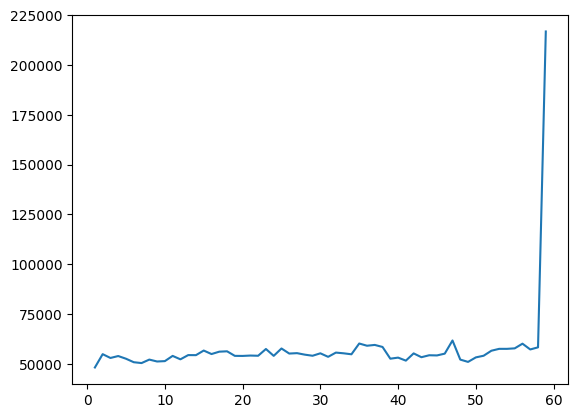

In [30]:
y = [row[2] for row in year_month_data.collect()][1:]
x =  np.linspace(1, len(y), len(y)) #[row['year_month'] for row in year_month_data.collect()][1:]
plt.plot(x,y)

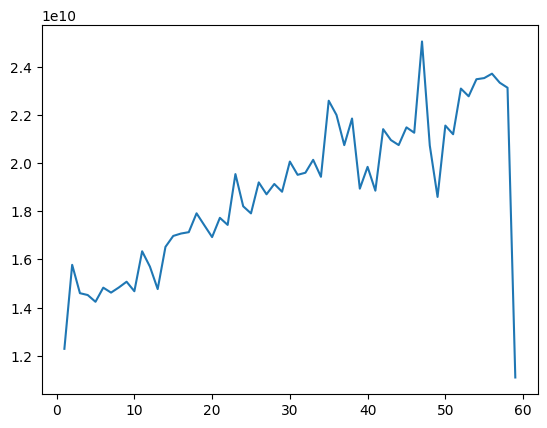

In [33]:
year_month_data = data.groupBy('year', 'month').agg(sum('streams').alias('sum_streams')).orderBy('year', 'month')
y = [row[2] for row in year_month_data.collect()][1:]
x =  np.linspace(1, len(y), len(y)) #[row['year_month'] for row in year_month_data.collect()][1:]
plt.plot(x,y)

In [178]:
spark.stop()